In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
46481,NaN,NaN,International,2020-09-25,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46482,NaN,NaN,International,2020-09-26,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46483,NaN,NaN,International,2020-09-27,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


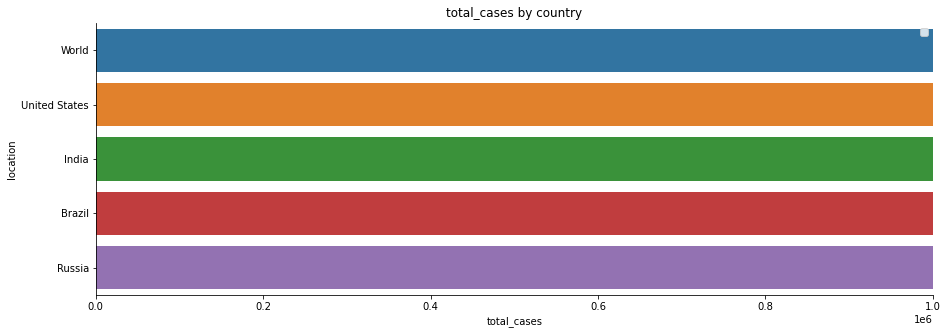

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


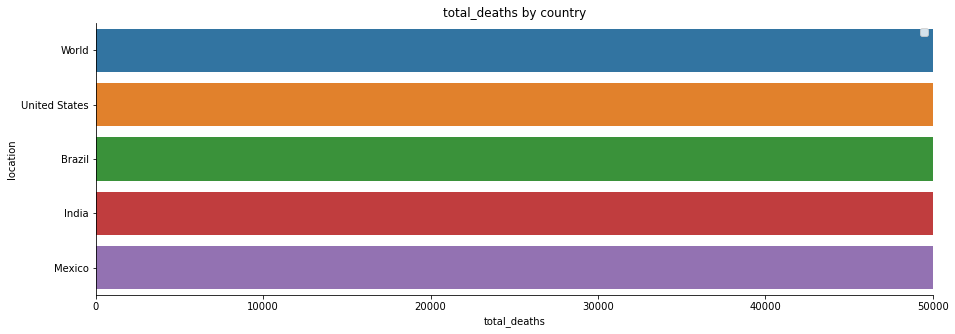

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


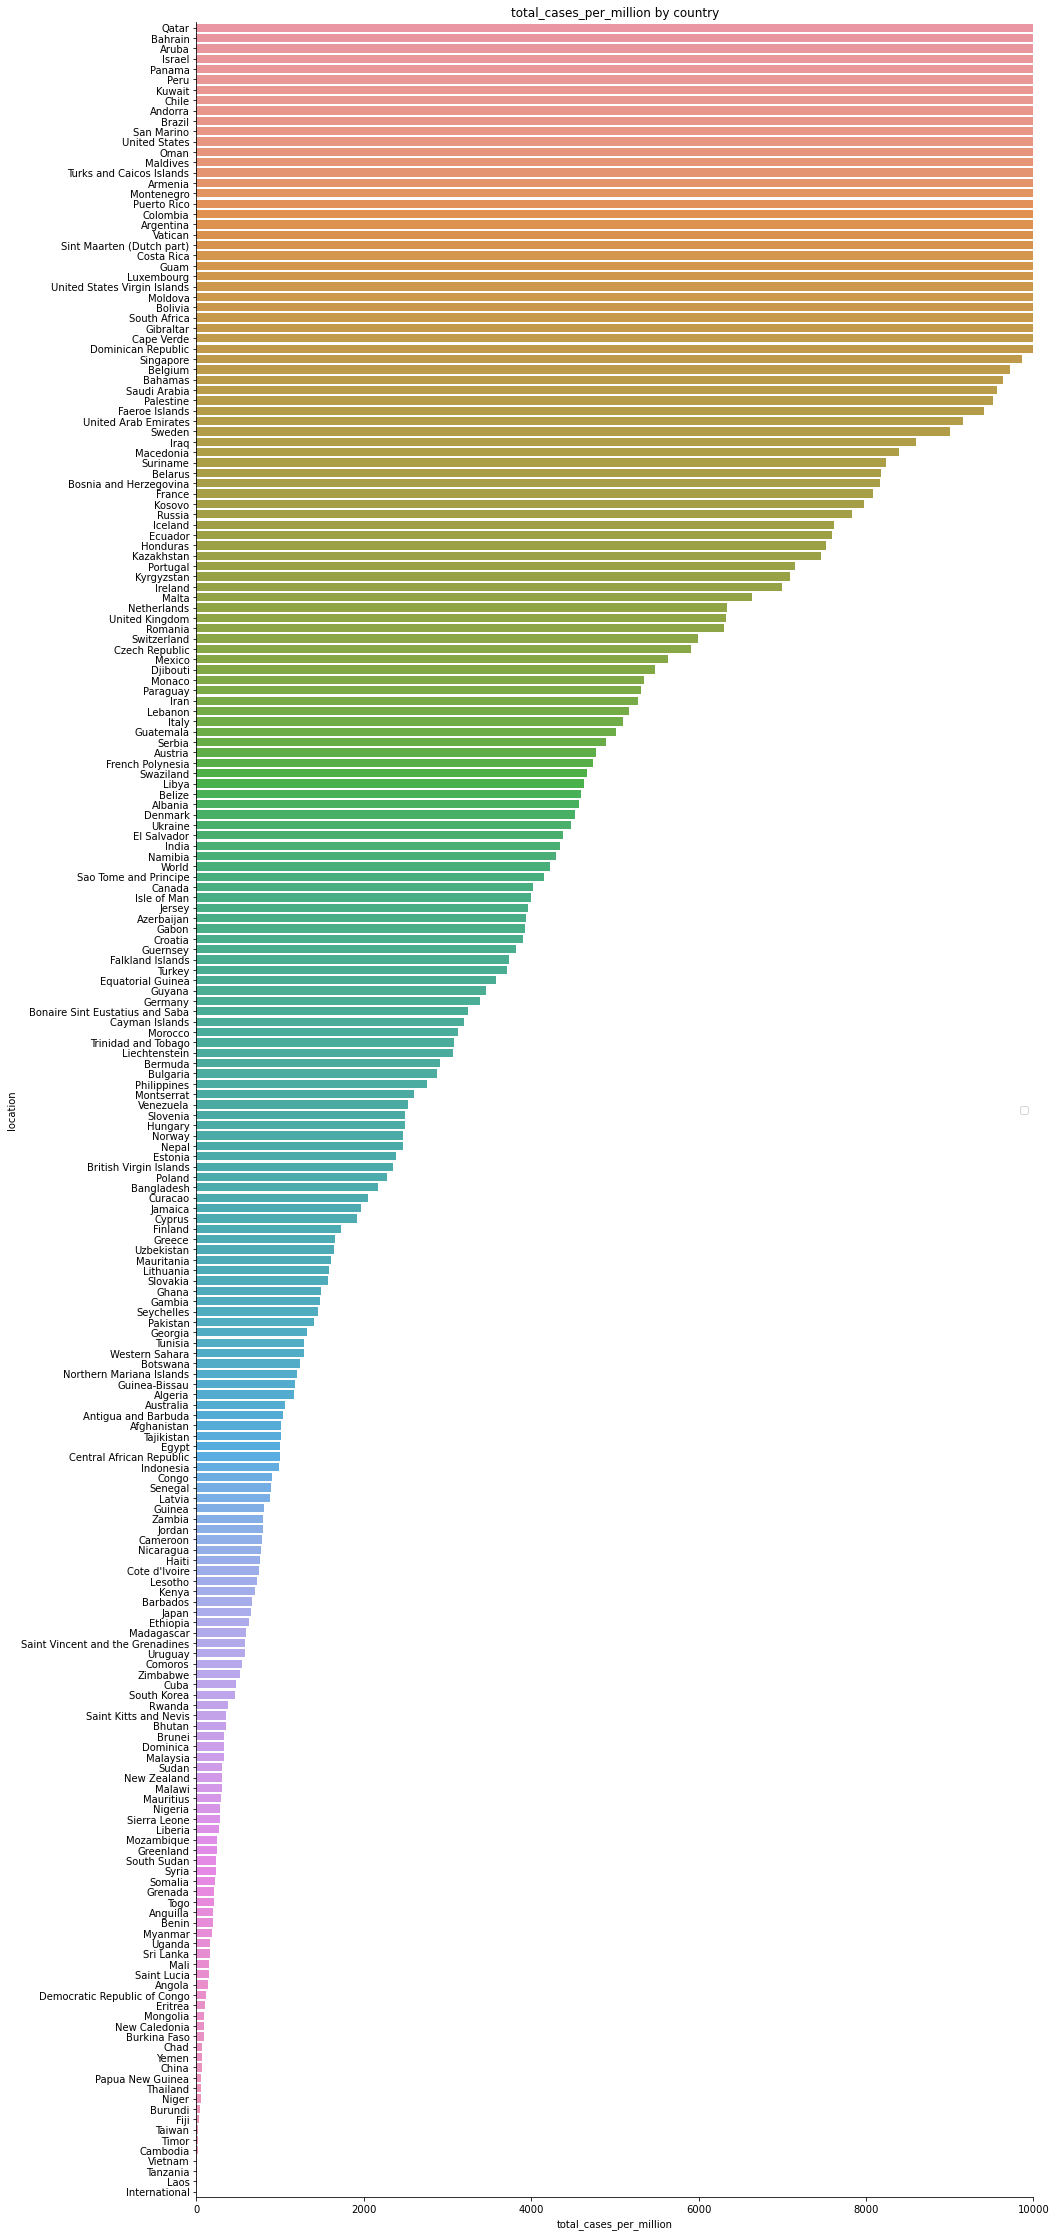

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


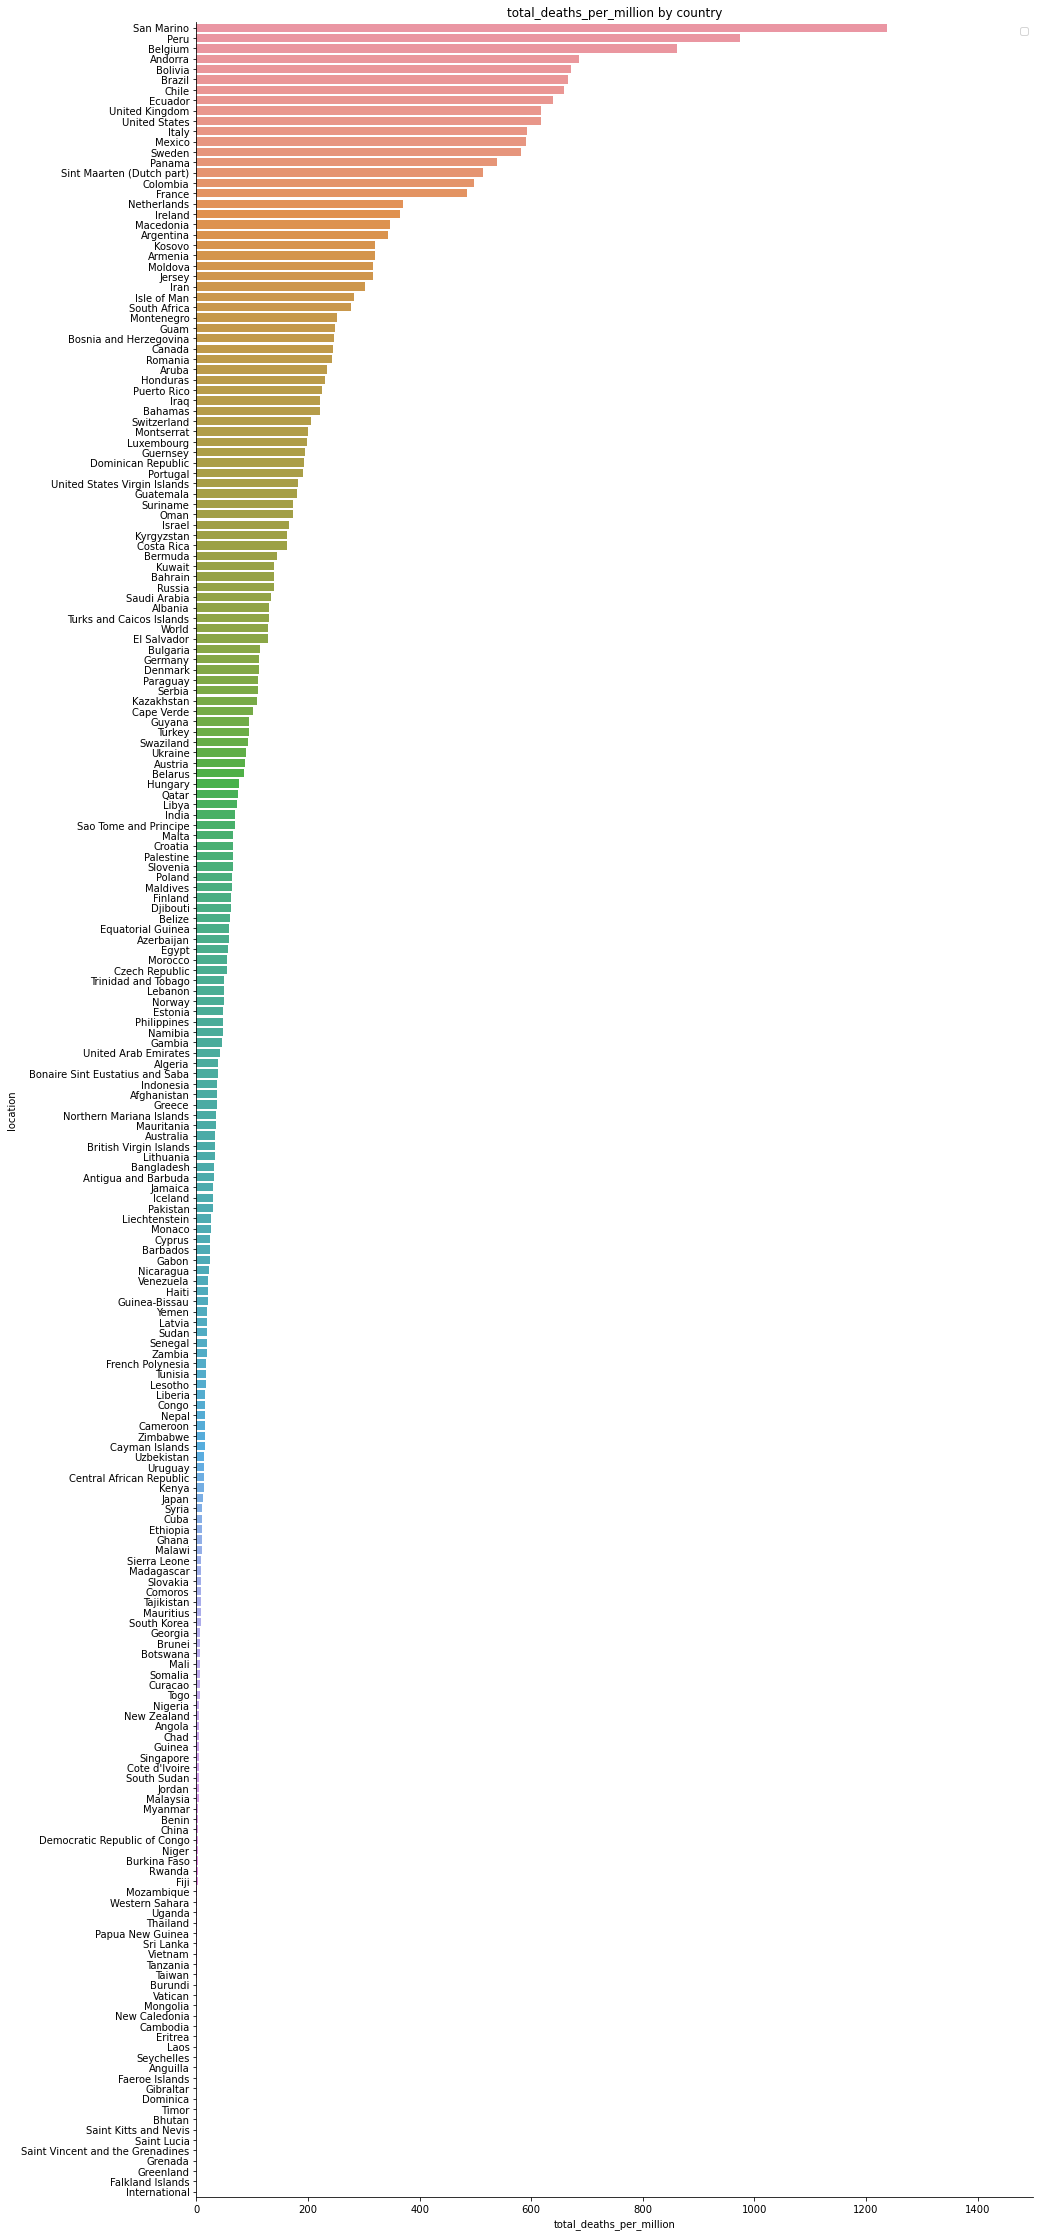

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

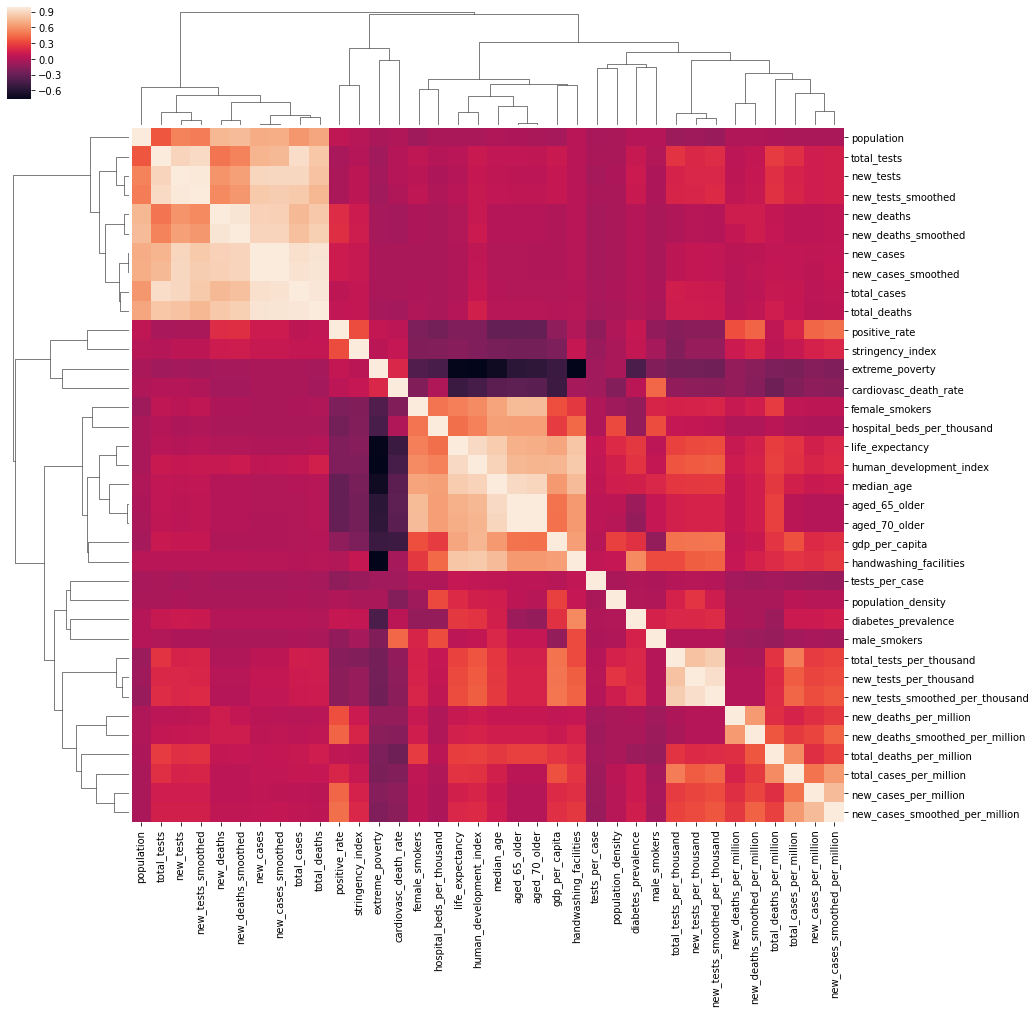

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.998479895840313 (+/- 0.0019857309338665347)
Coef :  [1.03075127e+00 7.83033288e-05 8.02779164e-05]
3 Last_days :  [[32304769 32615251 32916707]]
Today :  32916707
Prediction + :  494385
Tomorow :  33411092
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996275815693546 (+/- 0.00015674982039518535)
Coef :  [0.25190814 0.36871745 0.38936494]
3 Last_days :  [[984158 989733 995147]]
Today :  995147
Prediction + :  8641
Tomorow :  1003788
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.034911516411025745 (+/- 1.4595429206456285)
Coef :  [-0.74231715  0.7703709   0.97850756]
3 Last_days :  [[497237 513034 527446]]
Today :  527446
Prediction + :  14582
Tomorow :  542028
                                     
--------- Total Death -----------------
                                     
R^2: 0.7362783742980686 (+/- 0.3639267274501155)
Coef :  [-0.74469833  0.78747667  0.95620194]
3 Last_days :  [[31511 31661 31700]]
Today :  31700
Prediction + :  131
Tomorow :  31831
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9676353979973196 (+/- 0.03378463657888349)
Coef :  [-0.33097205 -0.00849308  1.33372951]
3 Last_days :  [[90424 90441 90456]]
Today :  90456
Prediction + :  19
Tomorow :  90475
                                     
--------- Total Death -----------------
                                     
R^2: -23.224138712095172 (+/- 34.158014818749784)
Coef :  [-0.07774911  0.01249474  1.05692493]
3 Last_days :  [[4738 4739 4739]]
Today :  4739
Prediction + :  5
Tomorow :  4744
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9207557600237656 (+/- 0.11090290497160755)
Coef :  [-0.80738272  0.89030162  0.91659505]
3 Last_days :  [[304323 306235 308104]]
Today :  308104
Prediction + :  1642
Tomorow :  309746
                                     
--------- Total Death -----------------
                                     
R^2: -0.2763885015057424 (+/- 1.7856562763013366)
Coef :  [-0.81797105  0.89444891  0.92250274]
3 Last_days :  [[35781 35801 35818]]
Today :  35818
Prediction + :  35
Tomorow :  35853
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6481423525499689 (+/- 0.4876847401239328)
Coef :  [-0.26159995  0.17518618  1.09459274]
3 Last_days :  [[704209 716481 716481]]
Today :  716481
Prediction + :  9161
Tomorow :  725642
                                     
--------- Total Death -----------------
                                     
R^2: 0.39369685417388195 (+/- 0.5818645828819045)
Coef :  [-0.73079653  0.64581586  1.08401281]
3 Last_days :  [[31118 31232 31232]]
Today :  31232
Prediction + :  92
Tomorow :  31324
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9245613024891709 (+/- 0.10394018869033786)
Coef :  [0.16542864 0.4214819  0.42560168]
3 Last_days :  [[6978417 7033430 7078798]]
Today :  7078798
Prediction + :  72204
Tomorow :  7151002
                                     
--------- Total Death -----------------
                                     
R^2: 0.9795866894075518 (+/- 0.02757738158072705)
Coef :  [-0.36696362  0.65510914  0.71466709]
3 Last_days :  [[202810 203774 204497]]
Today :  204497
Prediction + :  1196
Tomorow :  205693
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9951353364404557 (+/- 0.005809379892248955)
Coef :  [-0.70488997  0.83566938  0.87061702]
3 Last_days :  [[416363 423236 429277]]
Today :  429277
Prediction + :  5122
Tomorow :  434399
                                     
--------- Total Death -----------------
                                     
R^2: 0.21530302957632108 (+/- 1.0789696250406167)
Coef :  [-0.76209388  0.82932953  0.93199122]
3 Last_days :  [[41902 41936 41971]]
Today :  41971
Prediction + :  56
Tomorow :  42027
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6843619317357043 (+/- 0.4455084446839614)
Coef :  [-0.77035715  0.84569641  0.9247256 ]
3 Last_days :  [[280223 282730 284140]]
Today :  284140
Prediction + :  2167
Tomorow :  286307
                                     
--------- Total Death -----------------
                                     
R^2: 0.21768207058681177 (+/- 1.0984238046813501)
Coef :  [-0.78153802  0.8381542   0.94256941]
3 Last_days :  [[9443 9452 9457]]
Today :  9457
Prediction + :  13
Tomorow :  9470
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9989684310849388 (+/- 0.0009562766265908072)
Coef :  [0.38431532 0.31552944 0.31161658]
3 Last_days :  [[436319 439882 443086]]
Today :  443086
Prediction + :  3123
Tomorow :  446209
                                     
--------- Total Death -----------------
                                     
R^2: 0.9156476730754156 (+/- 0.11847566607315105)
Coef :  [0.19997753 0.41205467 0.39936523]
3 Last_days :  [[25015 25222 25394]]
Today :  25394
Prediction + :  216
Tomorow :  25610
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9996167403841509 (+/- 0.0002697318592284375)
Coef :  [-0.60025622  0.78603084  0.81164864]
3 Last_days :  [[309790 311455 312966]]
Today :  312966
Prediction + :  1307
Tomorow :  314273
                                     
--------- Total Death -----------------
                                     
R^2: 0.9992304672455928 (+/- 0.000678598013165564)
Coef :  [-0.81806099  0.89692709  0.91967655]
3 Last_days :  [[7785 7858 7929]]
Today :  7929
Prediction + :  60
Tomorow :  7989
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9473027265843729 (+/- 0.07080611832914731)
Coef :  [-0.10870371  0.50908623  0.61132145]
3 Last_days :  [[4657702 4689613 4717991]]
Today :  4717991
Prediction + :  56430
Tomorow :  4774421
                                     
--------- Total Death -----------------
                                     
R^2: 0.4560316868509089 (+/- 0.7620685449999458)
Coef :  [-0.01092561  0.47865222  0.54228028]
3 Last_days :  [[139808 140537 141406]]
Today :  141406
Prediction + :  1374
Tomorow :  142780
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(32916707, 995147, 33411092, 1003788),
 (527446, 31700, 542028, 31831),
 (308104, 35818, 309746, 35853),
 (716481, 31232, 725642, 31324),
 (7078798, 204497, 7151002, 205693),
 (90456, 4739, 90475, 4744),
 (429277, 41971, 434399, 42027),
 (284140, 9457, 286307, 9470),
 (443086, 25394, 446209, 25610),
 (312966, 7929, 314273, 7989),
 (4717991, 141406, 4774421, 142780)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-27,France,542028.0,0.0,31831.0,0.0,0.0,0.0
0,2020-09-27,China,90475.0,0.0,4744.0,0.0,0.0,0.0
0,2020-09-27,Italy,309746.0,0.0,35853.0,0.0,0.0,0.0
0,2020-09-27,Spain,725642.0,0.0,31324.0,0.0,0.0,0.0
0,2020-09-27,United States,7151002.0,0.0,205693.0,0.0,0.0,0.0
0,2020-09-27,World,33411092.0,0.0,1003788.0,0.0,0.0,0.0
0,2020-09-27,United Kingdom,434399.0,0.0,42027.0,0.0,0.0,0.0
0,2020-09-27,Germany,286307.0,0.0,9470.0,0.0,0.0,0.0
0,2020-09-27,Iran,446209.0,0.0,25610.0,0.0,0.0,0.0
0,2020-09-27,Turkey,314273.0,0.0,7989.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")